# TRABAJO  FINAL - VISIÓN POR COMPUTADORA II

Integrantes:
*  Baffo, Agustín
*  Barria, Alex
*  Spak, Joel

En este trabajo se utilizará el dataset kannada MNIST. Kannada es un lenguaje que se utiliza principalmente en India. 

El objetivo será abordar el problema de clasificación multiclase de identificar 10 dígitos como los que se ven en la figura.


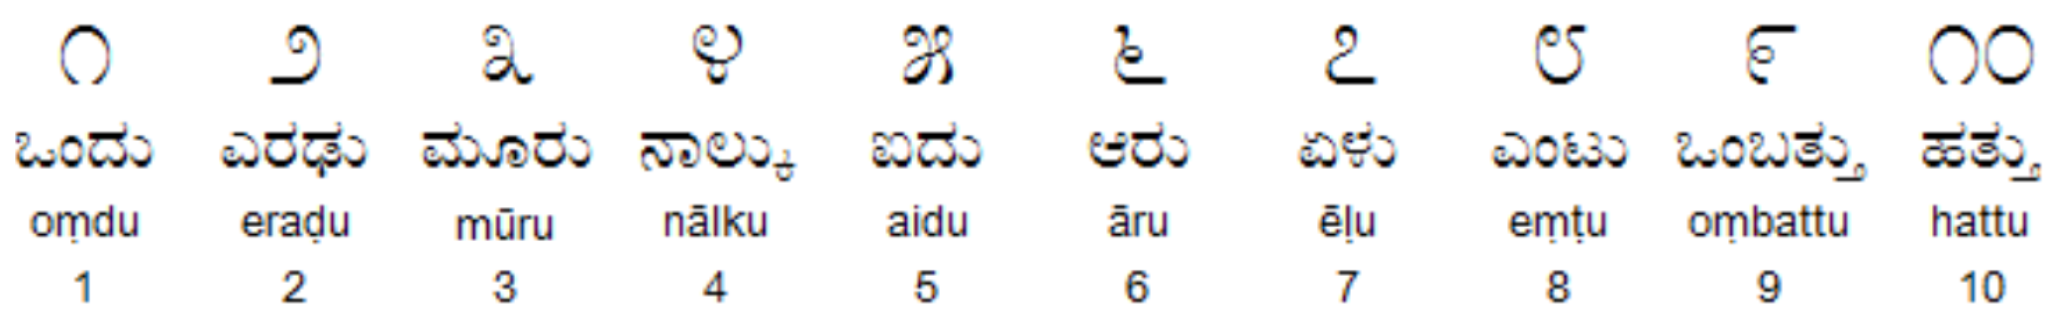

Para encontrar una solución primero se plantea un modelo base de regresión logística, para ir avanzando en complejidad hacia un modelo LeNet y por último utilizar una arquitectura VGG16 con transfer learning.

Es importante mencionar que el ajuste fino de los hiper-parámetros (HPs) no forma parte del trabajo. Si bien se realizaron algunas pruebas variando el learning rate, cantidad de neuronas por capa, etc, el ajuste fino de los HPs escapa al objetivo de este trabajo y podría mejorar significativamente el desempeño de los modelos presentados.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle

# Train-Test
from sklearn.model_selection import train_test_split

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Cargar datos

In [ ]:
!gdown --id 1Th5WMO3Ea_2ceIunA-wnJ8dTa-q7Kg-h

Downloading...
From: https://drive.google.com/uc?id=1Th5WMO3Ea_2ceIunA-wnJ8dTa-q7Kg-h
To: /content/Kannada-MNIST.zip
100% 11.8M/11.8M [00:00<00:00, 68.6MB/s]


In [ ]:
!rm -r Kannada-MNIST
!unzip /content/Kannada-MNIST.zip > /dev/null

In [ ]:
df_train = pd.read_csv('/content/Kannada-MNIST/train.csv')
df_test = pd.read_csv('/content/Kannada-MNIST/test.csv')

In [ ]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Train validation split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop(['label'], axis=1),
    df_train['label'],
    test_size=0.15,
    random_state=0
)

x_test = df_test.drop(columns='label')
y_test = df_test['label']

In [ ]:
print("La longitud del conjunto de datos de train es: "+str(len(x_train)))
print("La longitud del conjunto de datos de validación es: "+str(len(x_val)))
print("La longitud del conjunto de datos de test es: "+str(len(x_test)))

La longitud del conjunto de datos de train es: 51000
La longitud del conjunto de datos de validación es: 9000
La longitud del conjunto de datos de test es: 10240


## Plotear algunos datos

El conjunto de entrenamiento tiene 51000 imágenes
El conjunto de validacion tiene 9000 imágenes
El conjunto de testeo tiene 10240 imágenes
Las imágenes son de: (28, 28)
Label de la imágen 0: 0
Label de la imágen 1: 1
Label de la imágen 2: 2
Label de la imágen 3: 3
Label de la imágen 4: 4
Label de la imágen 5: 5
Label de la imágen 6: 6
Label de la imágen 7: 7
Label de la imágen 8: 8


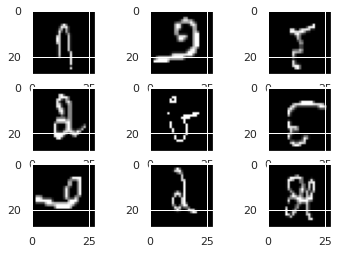

In [ ]:
print("El conjunto de entrenamiento tiene {} imágenes".format(len(x_train)))
print("El conjunto de validacion tiene {} imágenes".format(len(x_val)))
print("El conjunto de testeo tiene {} imágenes".format(len(x_test)))
print("Las imágenes son de: {}".format(np.array(x_train)[0].reshape(28,28).shape))

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):

  plt.subplot(331 + i)
  plt.imshow(np.array(x_train)[i].reshape(28,28), cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, y_train[i]))

plt.show()

## Escalado de datos

In [ ]:
x_train_scaled = x_train/255.0
x_val_scaled = x_val/255.0
x_test_scaled = x_test/255.0

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## Predicción usando Regresión logistica

In [ ]:
# LogisticRegression
clf = LogisticRegression(multi_class='multinomial',C=2)
clf.fit(x_train_scaled, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=2, multi_class='multinomial')

In [ ]:
y_pred = clf.predict(x_val_scaled)
metrics.accuracy_score(y_val, y_pred)

0.9681111111111111

In [ ]:
y_pred = clf.predict(x_test_scaled)
metrics.accuracy_score(y_test, y_pred)

0.5931640625

## Codificación de etiquetas con One Hot Encoding

In [ ]:
y_train = tf.one_hot(y_train, 10)
y_val = tf.one_hot(y_val, 10)
y_test = tf.one_hot(y_test, 10)

## Carga de datos con ImageDataGenerator

In [ ]:
lenet_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   rescale=1./255
                                   )

train_generator_lenet = lenet_datagen.flow(x_train.values.reshape(x_train_scaled.shape[0],28,28,1), y_train, batch_size=128)
valid_generator_lenet = lenet_datagen.flow(x_val.values.reshape(x_val_scaled.shape[0],28,28,1), y_val, batch_size=128)
test_generator_lenet = lenet_datagen.flow(x_test.values.reshape(x_test_scaled.shape[0],28,28,1), y_test, batch_size=128)

# LeNet

In [ ]:
lenet5_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="tanh"),
    tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="tanh"),
    tf.keras.layers.AveragePooling2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=120, kernel_size=3, strides=1, padding="valid", activation="tanh"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation="tanh"),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

lenet5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 120)         17400     
                                                                 
 flatten (Flatten)           (None, 480)               0

In [ ]:
lenet5_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
lenet5_history = lenet5_model.fit(train_generator_lenet,
                                  epochs=10,
                                  validation_data=valid_generator_lenet)
                                  # callbacks=[tf.keras.callbacks.TensorBoard(), tf.keras.callbacks.ModelCheckpoint()])

Epoch 1/10
399/399 [==============================] - 42s 99ms/step - loss: 1.0731 - categorical_accuracy: 0.6364 - val_loss: 0.5827 - val_categorical_accuracy: 0.8098
Epoch 2/10
399/399 [==============================] - 41s 102ms/step - loss: 0.4786 - categorical_accuracy: 0.8449 - val_loss: 0.3776 - val_categorical_accuracy: 0.8748
Epoch 3/10
399/399 [==============================] - 39s 98ms/step - loss: 0.3811 - categorical_accuracy: 0.8788 - val_loss: 0.3552 - val_categorical_accuracy: 0.8864
Epoch 4/10
399/399 [==============================] - 38s 96ms/step - loss: 0.3468 - categorical_accuracy: 0.8901 - val_loss: 0.3398 - val_categorical_accuracy: 0.8939
Epoch 5/10
399/399 [==============================] - 39s 97ms/step - loss: 0.3140 - categorical_accuracy: 0.9001 - val_loss: 0.2988 - val_categorical_accuracy: 0.9060
Epoch 6/10
399/399 [==============================] - 39s 97ms/step - loss: 0.3032 - categorical_accuracy: 0.9055 - val_loss: 0.3284 - val_categorical_accuracy

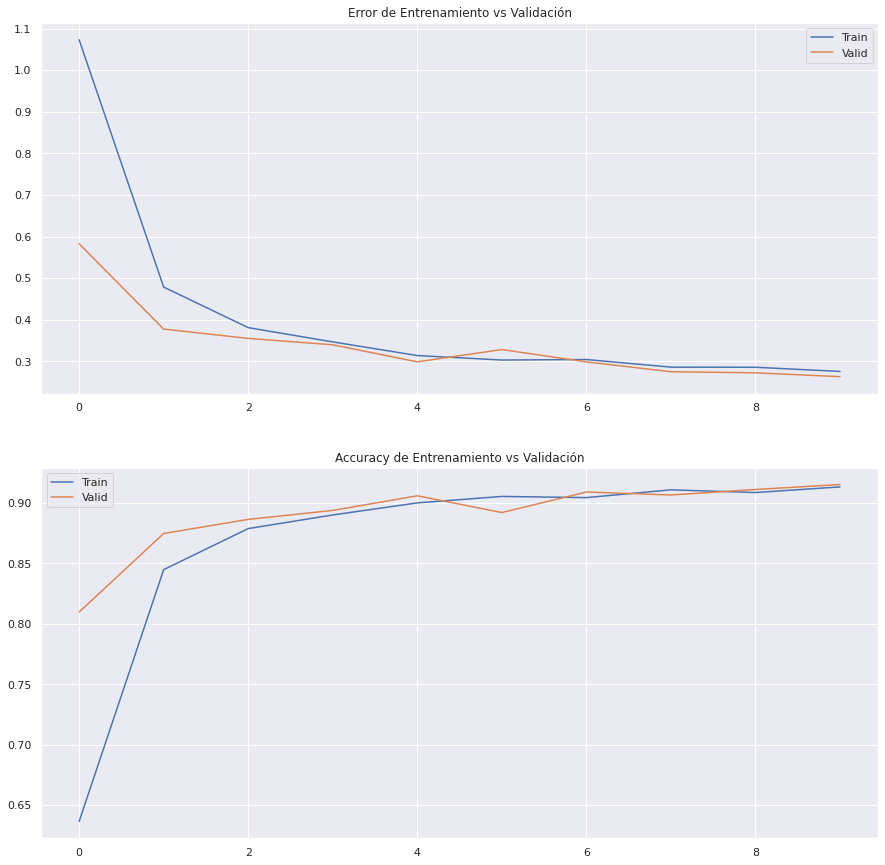

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(lenet5_history.history['loss']) 
axs[0].plot(lenet5_history.history['val_loss']) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(lenet5_history.history['categorical_accuracy']) 
axs[1].plot(lenet5_history.history['val_categorical_accuracy']) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [ ]:
results = lenet5_model.evaluate(test_generator_lenet)

print("El modelo logro un error de {} y una accuracy de {}".format(results[0], results[1]))

80/80 [==============================] - 7s 84ms/step - loss: 1.5303 - categorical_accuracy: 0.6396
El modelo logro un error de 1.5303306579589844 y una accuracy de 0.6396484375


# Transfer learning

### Data generator

In [ ]:
def pre_process_df(df):
  # Imágenes de (28, 28)
  df = np.array(df).reshape(-1, 28, 28, 1)

  # Imágenes de (28, 28, 1)
  df = np.pad(df, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant', constant_values = (0,0))

  df = [np.dstack((x,x,x)) for x in df]

  # Imágenes de (32, 32, 1) o (32, 32, 3) 
  print("Las imágenes quedan de: {}".format(df[0].shape))
  
  return np.array(df)/255

In [ ]:
x_train_prepro = pre_process_df(x_train)
x_val_prepro = pre_process_df(x_val)
x_test_prepro = pre_process_df(x_test)

Las imágenes quedan de: (32, 32, 3)
Las imágenes quedan de: (32, 32, 3)
Las imágenes quedan de: (32, 32, 3)


In [ ]:
vgg_datagen = ImageDataGenerator(  width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   rescale=1./255,
                                   )

train_generator_vgg = vgg_datagen.flow(x_train_prepro, y_train, batch_size=128)
valid_generator_vgg = vgg_datagen.flow(x_val_prepro, y_val, batch_size=128)
test_generator_vgg = vgg_datagen.flow(x_test_prepro, y_test, batch_size=128)

In [ ]:
print(np.array(next(iter(train_generator_vgg))[0]).shape)
print(np.array(next(iter(valid_generator_vgg))[0]).shape)
print(np.array(next(iter(test_generator_vgg))[0]).shape)

(128, 32, 32, 3)
(128, 32, 32, 3)
(128, 32, 32, 3)


In [ ]:
vgg_base = tf.keras.applications.VGG16(weights='imagenet',
                                       include_top=False,
                                       input_shape=(32, 32, 3))

vgg_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

## Congelo las capas de la red base

El primer paso para realizar Transfer Learning seria congelar las capas del modelo base seleccionado. 

In [ ]:
vgg_base.trainable = False

Luego, agregamos las capas para armar el clasificador que querramos. En este caso, agregamos una capa de 512 neuronas y la salida con 2 unidades.

In [ ]:
vgg_model = tf.keras.Sequential()

vgg_model.add(vgg_base)

vgg_model.add(tf.keras.layers.Flatten())
vgg_model.add(tf.keras.layers.Dense(256, activation='relu'))
vgg_model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
vgg_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),    
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

vgg16 = vgg_model.fit(train_generator_vgg,
                                  epochs=10,
                                  validation_data=valid_generator_vgg)
                                  # callbacks=[tf.keras.callbacks.TensorBoard(), tf.keras.callbacks.ModelCheckpoint()])

Epoch 1/10
399/399 [==============================] - 65s 157ms/step - loss: 0.7440 - categorical_accuracy: 0.7492 - val_loss: 0.4180 - val_categorical_accuracy: 0.8476
Epoch 2/10
399/399 [==============================] - 62s 155ms/step - loss: 0.3932 - categorical_accuracy: 0.8676 - val_loss: 0.3941 - val_categorical_accuracy: 0.8581
Epoch 3/10
399/399 [==============================] - 63s 158ms/step - loss: 0.3275 - categorical_accuracy: 0.8908 - val_loss: 0.2633 - val_categorical_accuracy: 0.9097
Epoch 4/10
399/399 [==============================] - 63s 158ms/step - loss: 0.3032 - categorical_accuracy: 0.9001 - val_loss: 0.2477 - val_categorical_accuracy: 0.9136
Epoch 5/10
399/399 [==============================] - 63s 158ms/step - loss: 0.2709 - categorical_accuracy: 0.9106 - val_loss: 0.2161 - val_categorical_accuracy: 0.9304
Epoch 6/10
399/399 [==============================] - 63s 158ms/step - loss: 0.2613 - categorical_accuracy: 0.9137 - val_loss: 0.2578 - val_categorical_acc

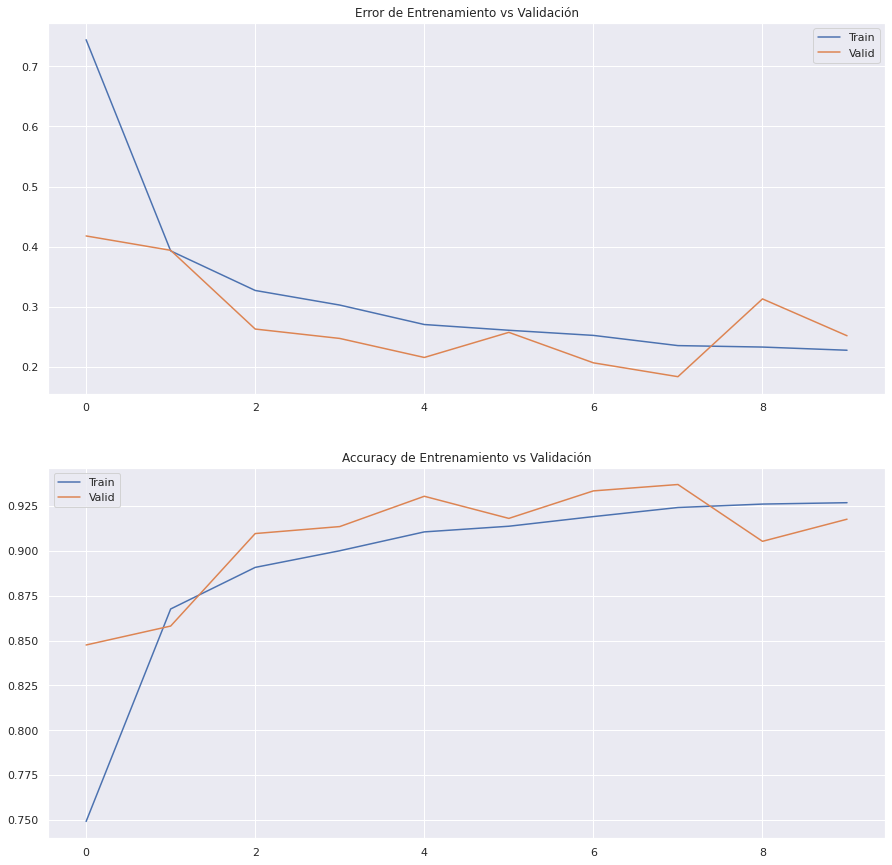

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(vgg16.history['loss']) 
axs[0].plot(vgg16.history['val_loss']) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(vgg16.history['categorical_accuracy']) 
axs[1].plot(vgg16.history['val_categorical_accuracy']) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [ ]:
results = vgg_model.evaluate(test_generator_vgg)

print("El modelo logro un error de {} y una accuracy de {}".format(results[0], results[1]))

80/80 [==============================] - 11s 135ms/step - loss: 1.8181 - categorical_accuracy: 0.6990
El modelo logro un error de 1.8180841207504272 y una accuracy de 0.699023425579071


# CONCLUSUIONES

## MÉTRICAS OBTENIDAS

Para la comparación de los modelos utilizamos la métrica *categorical accuracy* obtenida por cada una de las arquitecturas en un conjuto de datos de test nunca antes visto por el modelo.

Los resultados obtenidos fueron:



*   **Logistic Regression:**    0.593
*   **LeNet:**                  0.639
*   **VGG16:**                  0.699


Podemos ver que los modelos compuestos por bloques convolucionales tuvieron una mejor performance sobre los datos de test que la regresión logística. Las métricas obtenidas se podrían mejorar incluyendo técnicas para evitar el sobre-entrenamiento como dropout o batch normalization.
 
Es importante mencionar que el uso de transfer learning facilita y brinda acceso rápidamente a arquitecturas pre-entrenadas, que de otra forma tardarían mucho tiempo en entrenar. Esto permite realizar una primera aproximación rápida con algún modelo ya entrenado sobre otro dataset.
 
Como se mencionó anteriormente, otro aspecto que mejoraría las métricas de cada modelo sería un ajuste fino de los hiper-parámetros. En este caso se podría utilizar grid-search, random-search o algún método de optimización bayesiana.

